In [5]:
import numpy as np
import pandas as pd
import os

In [4]:
!ls data/imagese

Screenshot 2022-10-26 123946.png Screenshot 2022-10-26 124205.png
Screenshot 2022-10-26 124105.png Screenshot 2022-10-26 124245.png


In [36]:
# old_img_names = os.listdir(os.path.join("data", "images"))
cwd = os.getcwd()
# old_img_paths = {img_name: os.path.join(cwd, "data", "images", img_name) for img_name in old_img_names}

# for img in old_img_paths:
#     if "Screenshot" in img:
#         new_name = img[-10:]
#         new_path = os.path.join(cwd, "data", "images", new_name)
#         old_path = old_img_paths[img]
#         os.rename(old_path, new_path)

img_names = os.listdir(os.path.join("data", "images"))
cwd = os.getcwd()
img_paths = {img_name: os.path.join(cwd, "data", "images", img_name) for img_name in img_names}
img_paths.keys()

dict_keys(['123946.png', '.DS_Store', '124245.png', '124105.png', '124205.png'])

In [37]:
!ls /Users/jordansmith/Library/CloudStorage/OneDrive-Reply/CarbonIntensityProject/Carbon-Intensity-Project-/data/images

123946.png 124105.png 124205.png 124245.png


PNG
(1990, 663)
RGBA


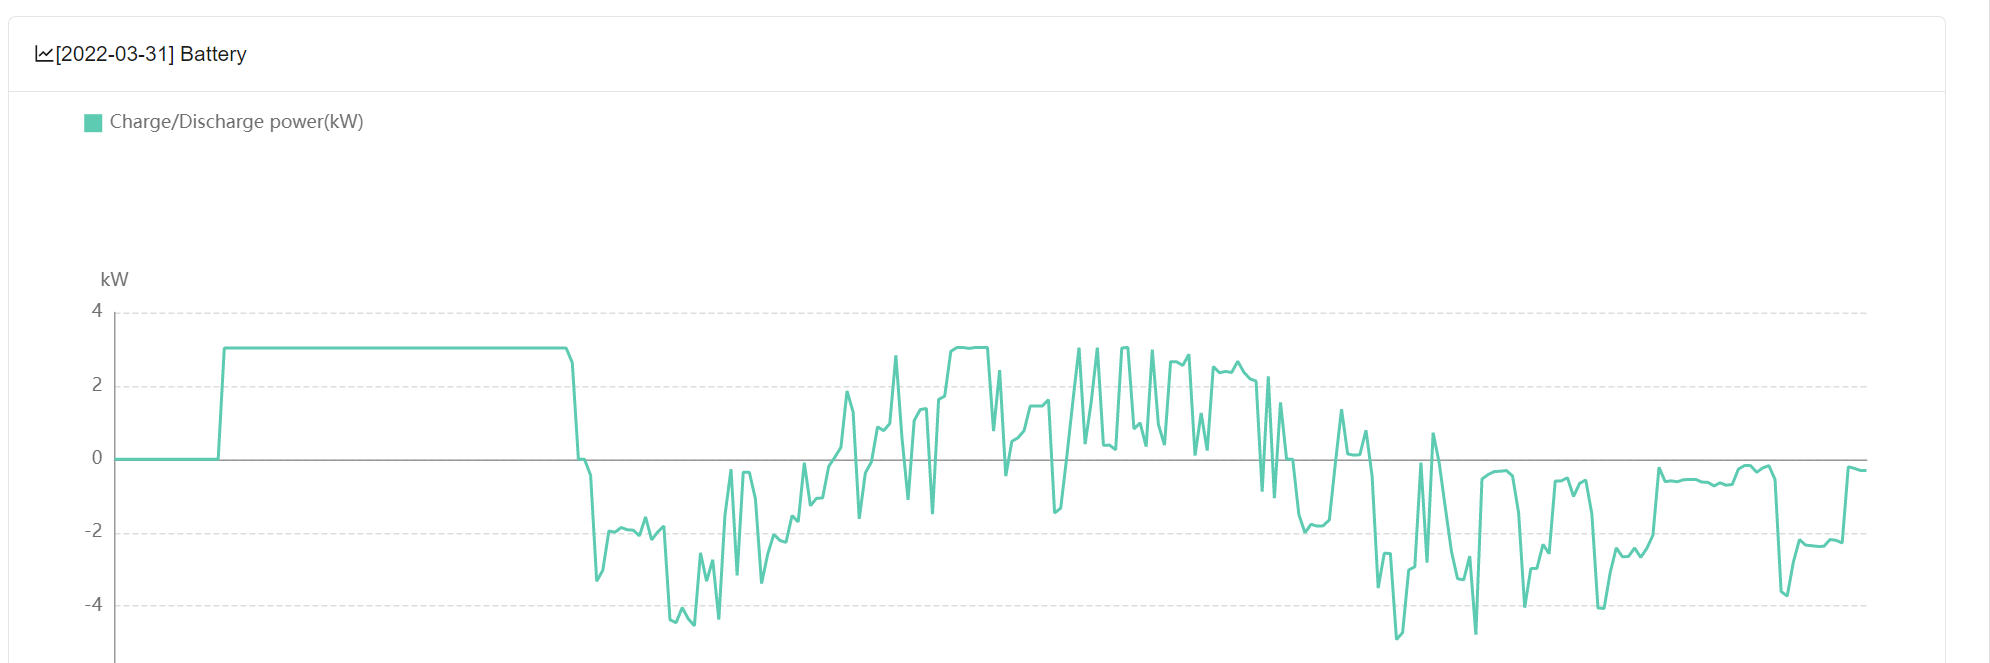

In [44]:
from PIL import Image
image = Image.open(img_paths[img_names[0]])
print(image.format)
print(image.size)
print(image.mode)
# show the image
image

In [56]:
data = np.asarray(image)
np.shape(data[:,:,1])

(663, 1990)

In [87]:
zoom_in = data[300:350,950:1000]
zoom_in.shape

(50, 50, 4)

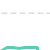

In [88]:
image2 = Image.fromarray(zoom_in)
image2

In [118]:
arr = zoom_in[:,:]
a_ = np.argwhere(arr != 255)

for i in range(len(a_)):
    vals_ = arr[a_[i][0], a_[i][1]]
    print(vals_)
    img_ = Image.fromarray(vals_)
    img_
    

[245 245 245 255]
[245 245 245 255]
[245 245 245 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[248 248 248 255]
[248 248 248 255]
[248 248 248 255]
[245 245 245 255]
[245 245 245 255]
[245 245 245 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[248 248 248 255]
[248 248 248 255]
[248 248 248 255]
[245 245 245 255]
[245 245 245 255]
[245 245 245 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 238 255]
[238 238 2

238